In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim

print("Using torch", torch.__version__)

Using torch 1.10.0+cu111


In [ ]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [ ]:
class LeNet_5(nn.Module):

    def __init__(self, no_of_convblocks = 2):
        super(LeNet_5, self).__init__()

        self.convblock1 = nn.Sequential(
                    nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2, dilation=1, groups=1, bias=True, padding_mode='zeros'),
                    nn.Tanh(),
                    nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False, count_include_pad=True, divisor_override=None))
        
        self.convblock2 = nn.Sequential(
                    nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros'),
                    nn.Tanh(),
                    nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False, count_include_pad=True, divisor_override=None))
        
        self.convblock3 = nn.Sequential(
                    nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros'),
                    nn.Tanh())
                    
        self.classifier = nn.Sequential(
                    nn.Linear(120, 84, bias=True, device=None, dtype=None),
                    nn.Tanh(),
                    nn.Linear(84, 10, bias=True, device=None, dtype=None),
                    nn.Softmax(dim=None))
      
    def extract_convblock1_tensors(self, X):
        return self.convblock1(X)

    def extract_convblock2_tensors(self, X):
        X = self.extract_convblock1_tensors(X)
        return self.convblock2(X)

    def forward(self, X):

        conv1_tensor = self.convblock1(X)
        conv2_tensor = self.convblock2(conv1_tensor)
        conv3_tensor = self.convblock3(conv2_tensor)
        output = torch.flatten(conv3_tensor, 1)

        return self.classifier(output)

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

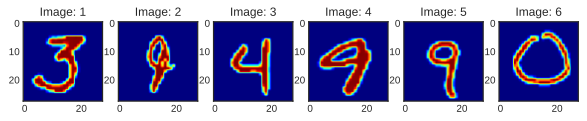

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
plt.style.use('seaborn-white')

fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(10,10))
for i, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    plt.imshow(example_data[i][0], cmap=plt.cm.jet) 
    plt.title('Image: {}'.format(i+1))

plt.show()

In [ ]:
network = LeNet_5()
print(network.parameters)

<bound method Module.parameters of LeNet_5(
  (convblock1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (convblock2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (convblock3): Sequential(
    (0): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=10, bias=True)
    (3): Softmax(dim=None)
  )
)>


In [ ]:
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(n_epochs):

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):

        inputs, labels = data

        optimizer.zero_grad()

        outputs = network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:    
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Finished Training


torch.Size([1, 28, 28])


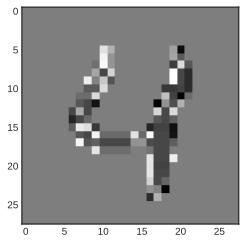

In [ ]:
test, label = test_loader.dataset[4]
print(test.shape)

transform = transforms.ToPILImage()
image = transform(test)
plt.imshow(image)

tensor = test[None,:]

In [ ]:
convblock1_tensors = torch.squeeze(network.extract_convblock1_tensors(tensor))
print('Volume of feature maps after convolutional block one ',convblock1_tensors.shape)

convblock2_tensors = torch.squeeze(network.extract_convblock2_tensors(tensor))
print('Volume of feature maps after convolutional block two ',convblock2_tensors.shape)


Volume of feature maps after convolutional block one  torch.Size([6, 14, 14])
Volume of feature maps after convolutional block two  torch.Size([16, 5, 5])


In [ ]:

def display(convblock_tensors,nrows, ncols):

  fig, axs = plt.subplots(nrows, ncols, figsize=(15,5))
  for i, ax in enumerate(axs.flatten()):
      plt.sca(ax)
      plt.imshow(convblock_tensors[i].detach().numpy(), cmap=plt.cm.jet)
      plt.title('Image: {}'.format(i+1))

  plt.show()

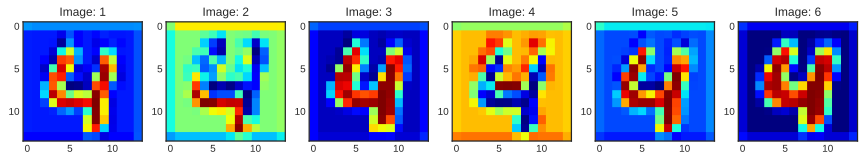

In [ ]:
display(convblock1_tensors,1,6)

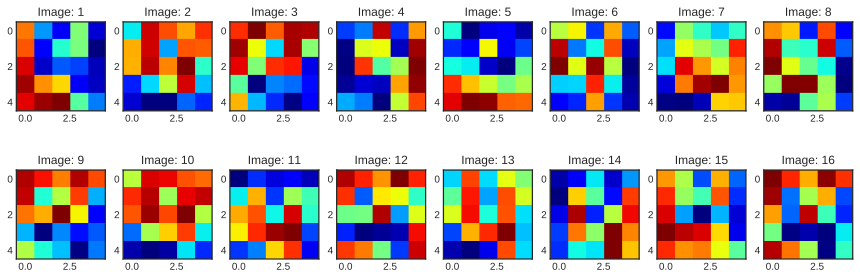

In [ ]:
display(convblock2_tensors,2,8)

In [ ]:
def display_(convblock_tensors,nrows, ncols, scale):

  fig, axs = plt.subplots(nrows, ncols, figsize=(15,5))
  for i, ax in enumerate(axs.flatten()):
      plt.sca(ax)
      X = convblock_tensors[i]
      X = F.interpolate(input=X[None,None,:,:], scale_factor=scale, align_corners=True, mode='bilinear')
      X = X.squeeze()
      relu = nn.ReLU()
      X = relu(X) 
      plt.imshow(X.detach().numpy(), cmap=plt.cm.jet)
      plt.title('Image: {}'.format(i+1))

  plt.show()

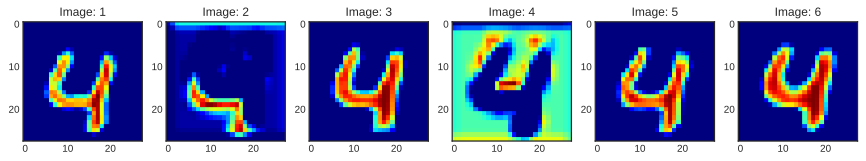

In [ ]:
display_(convblock1_tensors,1,6,2)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


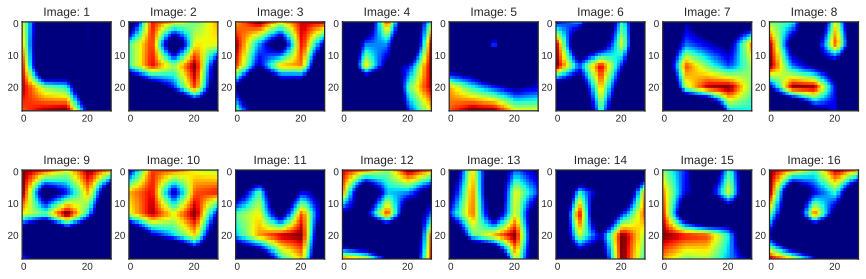

In [ ]:
display_(convblock2_tensors,2,8,5.6)

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = network(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 1000 test images: {100 * correct // total} %')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Accuracy of the network on the 1000 test images: 74 %
